# Final Project

In [100]:
# Import statements
import os
import re
import nltk
import pandas as pd
import numpy as np
from afinn import Afinn
import matplotlib.pyplot as plt
from bokeh.models import HoverTool, ColumnDataSource, Panel
from bokeh.models.widgets import CheckboxGroup, Tabs
from bokeh.layouts import gridplot, column, row, WidgetBox
from bokeh.plotting import figure, show, output_file

In [19]:
def create_df(c):
    df = pd.DataFrame()
    divider = []
    names = []
    for f in os.listdir("tweets/%s" % c):
        try:
            dft = pd.read_csv("tweets/%s/%s" % (c, f))
            if len(divider) == 0:
                divider.append(len(dft) - 1)
            else:
                divider.append(len(dft) + divider[-1])
            df = pd.concat([df, dft])
            
            # parse output_name.csv string
            names.append(f[7:][:-4])
        except:
            print(f)
    return df, divider, names

In [20]:
categories = ["fast food", "airlines", "leagues", "colleges", "streaming platforms", "news", "tech giants", "celebrities"]

fast_food, ff_divider, ff_names = create_df(categories[0])
airlines, al_divider, al_names = create_df(categories[1])
leagues, lg_divider, lg_names = create_df(categories[2])
colleges, cl_divider, cl_names = create_df(categories[3])
streaming, st_divider, st_names = create_df(categories[4])
news, nw_divider, nw_names = create_df(categories[5])
tech, tg_divider, tg_names = create_df(categories[6])
celebs, cb_divider, cb_names = create_df(categories[7])


In [21]:
stopwords = nltk.corpus.stopwords.words("english")

# Clean tweets for sentiment analysis
def get_clean_words(words):
    def _isnum(w):
        try:
            int(w)
            return True
        except ValueError:
            return False
        
    # Set words to lowercase and remove them if they are stop words
    words = [w.lower() for w in words if w.lower() not in stopwords]

    # Remove punctuation
    words = [w.replace('(', '') for w in words]
    words = [w.replace(')', '') for w in words]
    words = [w.replace('?', '') for w in words]
    words = [w.replace(',', '') for w in words]
    words = [w.replace('.', '') for w in words]
    words = [w.replace('"', '') for w in words]
    words = [w.replace('!', '') for w in words]
    words = [w.replace(':', '') for w in words]

    # Remove numbers
    words = [w for w in words if not _isnum(w)]
    
    # Remove links
    words = [w for w in words if 'http' not in w]
        
    # Remove hashtags
    words = [w for w in words if not w.startswith("#")]
    
    # Remove mentions
    words = [w for w in words if not w.startswith("@")]
    
    # Only keep words with more than one character
    words = [w for w in words if len(w) > 1]

    return words

In [39]:
def clean_tweets(tweets):
    t_new = []
    count = 0
    for t in tweets:
        try:
            w = t.split()
            w = get_clean_words(w)
            tc = " ".join(w)
            t_new.append(tc)
        except:
            count += 1
    return t_new

In [41]:
ff_tweets = list(fast_food['text'])
al_tweets = list(airlines['text'])
lg_tweets = list(leagues['text'])
cl_tweets = list(colleges['text'])
st_tweets = list(streaming['text'])
nw_tweets = list(news['text'])
tg_tweets = list(tech['text'])
cb_tweets = list(celebs['text'])

ff_clean = clean_tweets(ff_tweets)
al_clean = clean_tweets(al_tweets)
lg_clean = clean_tweets(lg_tweets)
cl_clean = clean_tweets(cl_tweets)
st_clean = clean_tweets(st_tweets)
nw_clean = clean_tweets(nw_tweets)
tg_clean = clean_tweets(tg_tweets)
cb_clean = clean_tweets(cb_tweets)

In [44]:
afinn = Afinn()

def get_affinity_scores(tweets):
    scores = []
    for t in tweets:
        try:
            if (len(t) > 0):
                scores.append(afinn.score(t) / len(t))
        except:
            print(t)
    return scores

In [45]:
ff_affin = get_affinity_scores(ff_clean)
al_affin = get_affinity_scores(al_clean)
lg_affin = get_affinity_scores(lg_clean)
cl_affin = get_affinity_scores(cl_clean)
st_affin = get_affinity_scores(st_clean)
nw_affin = get_affinity_scores(nw_clean)
tg_affin = get_affinity_scores(tg_clean)
cb_affin = get_affinity_scores(cb_clean)

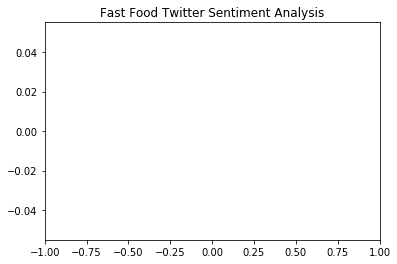

In [9]:
plt.hist(ff_affin, bins = 20)
plt.xlim([-1, 1])
plt.title("Fast Food Twitter Sentiment Analysis")
plt.show()

In [10]:
plt.hist(al_affin, bins = 20)
plt.xlim([-1, 1])
plt.title("Airline Twitter Sentiment Analysis")
plt.show()

NameError: name 'al_affin' is not defined

In [ ]:
plt.hist(lg_affin, bins = 20)
plt.xlim([-1, 1])
plt.title("Sports League Twitter Sentiment Analysis")
plt.show()

In [ ]:
plt.hist(cl_affin, bins = 20)
plt.xlim([-1, 1])
plt.title("College Twitter Sentiment Analysis")
plt.show()

In [ ]:
plt.hist(st_affin, bins = 20)
plt.xlim([-1, 1])
plt.title("Streaming Site Twitter Sentiment Analysis")
plt.show()

In [ ]:
plt.hist(nw_affin, bins = 20)
plt.xlim([-1, 1])
plt.title("News Outlet Twitter Sentiment Analysis")
plt.show()

In [ ]:
plt.hist(tg_affin, bins = 20)
plt.xlim([-1, 1])
plt.title("Tech Giant Twitter Sentiment Analysis")
plt.show()

In [ ]:
plt.hist(cb_affin, bins = 20)
plt.xlim([-1, 1])
plt.title("Celebrity Twitter Sentiment Analysis")
plt.show()

In [ ]:
def affin_by_acct(tweets, divider):
    acct = []
    start = 0
    for x in range(len(divider)):
        acct.append(np.mean(get_affinity_scores(tweets[start:divider[x]])))
        start = divider[x] + 1
    return acct

In [ ]:
ff_acct = affin_by_acct(ff_clean, ff_divider)
al_acct = affin_by_acct(al_clean, al_divider)
lg_acct = affin_by_acct(lg_clean, lg_divider)
cl_acct = affin_by_acct(cl_clean, cl_divider)
st_acct = affin_by_acct(st_clean, st_divider)
nw_acct = affin_by_acct(nw_clean, nw_divider)
tg_acct = affin_by_acct(tg_clean, tg_divider)
cb_acct = affin_by_acct(cb_clean, cb_divider)

In [ ]:
plt.bar(ff_names, ff_acct)
plt.title("Fast Food Twitter Sentiment Analysis")
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.bar(al_names, al_acct)
plt.title("Airline Twitter Sentiment Analysis by Account")
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.bar(lg_names, lg_acct)
plt.title("Sports League Twitter Sentiment Analysis by Account")
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.bar(cl_names, cl_acct)
plt.title("College Twitter Sentiment Analysis by Account")
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.bar(st_names, st_acct)
plt.title("Streaming Site Twitter Sentiment Analysis by Account")
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.bar(nw_names, nw_acct)
plt.title("News Outlet Twitter Sentiment Analysis by Account")
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.bar(tg_names, tg_acct)
plt.title("Tech Giant Twitter Sentiment Analysis by Account")
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.bar(cb_names, cb_acct)
plt.title("Celebrity Twitter Sentiment Analysis by Account")
plt.xticks(rotation=45)
plt.show()

In [104]:
start = -1
end = 1
bin_ct = 30


ff_hist, ff_edges = np.histogram(ff_affin, bins = bin_ct, range = [start, end])
al_hist, al_edges = np.histogram(al_affin, bins = bin_ct, range = [start, end])
lg_hist, lg_edges = np.histogram(lg_affin, bins = bin_ct, range = [start, end])
cl_hist, cl_edges = np.histogram(cl_affin, bins = bin_ct, range = [start, end])
st_hist, st_edges = np.histogram(st_affin, bins = bin_ct, range = [start, end])
nw_hist, nw_edges = np.histogram(nw_affin, bins = bin_ct, range = [start, end])
tg_hist, tg_edges = np.histogram(tg_affin, bins = bin_ct, range = [start, end])
cb_hist, cb_edges = np.histogram(cb_affin, bins = bin_ct, range = [start, end])

hist = [ff_hist, al_hist, lg_hist, cl_hist, st_hist, nw_hist, tg_hist, cb_hist]
hist = [[hh / np.sum(h) for hh in h] for h in hist1]

edges = [ff_edges, al_edges, lg_edges, cl_edges, st_edges, nw_edges, tg_edges, cb_edges]
colors = ['red', 'orange', 'lightgreen', 'darkgreen', 'lightblue', 'navy', 'violet', 'darkviolet']
categories = ["Fast Food", "Airlines", "Sports Leagues", "Colleges", "Streaming Sites", "News Outlets", "Tech Giants", "Celebrities"]


In [107]:
p = figure(plot_width = 700, plot_height = 700, 
                  title = 'Histogram of Sentiment Analysis by Category',
                  x_axis_label = 'Sentiment Score', y_axis_label = 'Proportion')


for i in range(len(hist)):
    p.quad(bottom = 0, top = hist[i], left = edges[i][:-1], right = edges[i][1:],
               color = colors[i], fill_alpha = 0.7, legend = categories[i],
               line_color = 'white')
p.legend.click_policy="hide"

show(p)
